# Quantum Machine Learning

Introduction to Quantum Machine Learning. I don't even know how to do regular machine learning, so this should be interesting...

## References
* https://docs.microsoft.com/en-us/quantum/install-guide/qjupyter
* https://github.com/microsoft/MLADS2020-QuantumClassification
* https://docs.microsoft.com/en-us/samples/microsoft/quantum/training-sequential-models-with-q-using-data-loaded-from-json/

In [21]:
# Setup

import math, json, random
from typing import List

import numpy as np
from matplotlib import pyplot
pyplot.style.use('ggplot')

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# Plotting configuration
cases = [(0, 0), (0, 1), (1, 1), (1, 0)]
markers = [
    '.' if actual == classified else 'X'
    for (actual, classified) in cases
]
colors = ['blue', 'blue', 'red', 'red']

# Q# configuration and necessary imports
import qsharp
qsharp.packages.add("Microsoft.Quantum.MachineLearning::0.11.2006.403")
qsharp.reload()

import QuantumClassification as QuantumClassification

print()
print("Setup complete!")

Adding package Microsoft.Quantum.MachineLearning::0.11.2006.403.
Setup complete!


In [16]:
# Data

def generate_data (samples_number : int, separation_angles : List[float]):
    """Generates data with 2 features and 2 classes separable by a line that goes through the origin"""
    features = []
    labels = []
    for i in range(samples_number):
        sample = [random.random(), random.random()]
        angle = math.atan2(sample[1], sample[0])
        features.append(sample)
        labels.append(0 if angle < separation_angles[0] or angle > separation_angles[1] else 1)
    
    data = { 'Features' : features, 'Labels' : labels }
    return data

# generate training and validation data using the same pair of separation angles
separation_angles = [math.pi / 6, math.pi / 3]
training_data = generate_data(150, separation_angles)
validation_data = generate_data(50, separation_angles)
print("Training and validation data generated")

Training and validation data generated


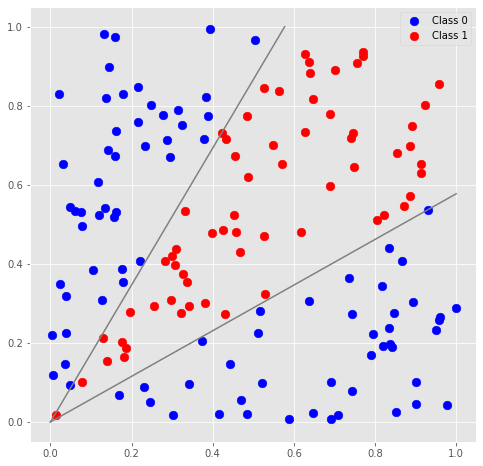

In [17]:
def plot_data (features : list, actual_labels : list, classified_labels : list = None, extra_lines : list = None):
    """Plots the data, labeling it with actual labels if there are no classification results provided, 
    and with the classification results (indicating their correctness) if they are provided.
    """
    samples = np.array(features)
    pyplot.figure(figsize=(8, 8))
    for (idx_case, ((actual, classified), marker, color)) in enumerate(zip(cases, markers, colors)):
        mask = np.logical_and(np.equal(actual_labels, actual), 
                              np.equal(actual if classified_labels == None else classified_labels, classified))
        if not np.any(mask): continue
        pyplot.scatter(
            samples[mask, 0], samples[mask, 1],
            label = f"Class {actual}" if classified_labels == None else f"Was {actual}, classified {classified}",
            marker = marker, s = 300, c = [color],
        )
    # Add the lines to show the true classes boundaries, if provided
    if extra_lines != None:
        for line in extra_lines:
            pyplot.plot(line[0], line[1], color = 'gray')
    pyplot.legend()
    
def separation_endpoint (angle : float) -> (float, float):
    if (angle < math.pi / 4):
        return (1, math.tan(angle))
    return (1/math.tan(angle), 1)

# Set up lines that show class separation
separation_lines = list(zip([(0,0), (0,0)], list(map(separation_endpoint, separation_angles))))
extra_lines = []
for line in separation_lines:
    extra_lines.append([[line[0][0], line[1][0]], [line[0][1], line[1][1]]])
    
plot_data(training_data['Features'], training_data['Labels'], extra_lines = extra_lines)

In [18]:
# Training 

(parameters, bias) = QuantumClassification.TrainLinearlySeparableModel.simulate(
    trainingVectors = training_data['Features'],
    trainingLabels = training_data['Labels'],
    initialParameters = [[1.0], [2.0]]
)

Training complete, found optimal parameters: [1.5424000000000115], -0.43235 with 0 misses


In [19]:
# Validation

# Validation parameters
tolerance = 0.0005
nMeasurements = 10_000

# Classify validation data set using training results
classified_labels = QuantumClassification.ClassifyLinearlySeparableModel.simulate(
    samples = validation_data['Features'],
    parameters = parameters, bias = bias,
    tolerance = tolerance, nMeasurements = nMeasurements
)

# Calculate miss rate
mask = np.not_equal(validation_data['Labels'], classified_labels)
miss_count = np.array(classified_labels)[np.where(mask)].size
miss_rate = miss_count / len(classified_labels)
print(f"Miss rate: {miss_rate:0.2%}")

Miss rate: 6.00%


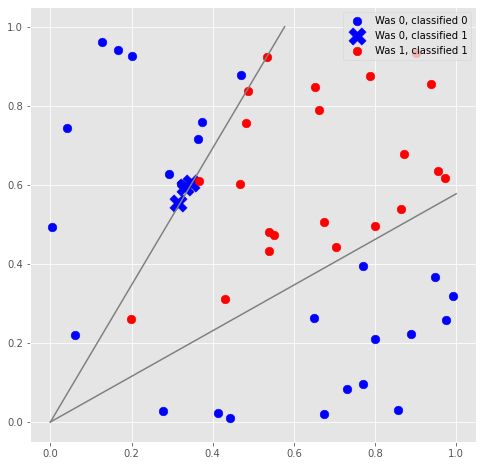

In [20]:
plot_data(validation_data['Features'], validation_data['Labels'], classified_labels, extra_lines)